# Introduction:

Here we are preparing the model that we used in the nyc_notebook to determine similar urban heat indexes for the greensburg area. 

# Libraries and Data:

##### Loading libraries:

In [2]:
# Machine Learning
from sklearn.ensemble import RandomForestRegressor

# Feature Engineering
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# Import Data Science Packages
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Import common GIS tools
import xarray as xr
import matplotlib.pyplot as plt
import rioxarray as rio
import rasterio
from matplotlib.cm import RdYlGn,jet,RdBu

# Geospatial raster data handling
import rioxarray as rxr

# Coordinate transformations
from pyproj import Proj, Transformer, CRS

# Others
import os
from tqdm import tqdm

# ckdTree for mapping 
from scipy.spatial import cKDTree

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

# Import Planetary Computer tools
import stackstac
import pystac_client
import planetary_computer 
from odc.stac import stac_load


# set the number of columns we see
pd.set_option('display.max_columns',None)

##### Mapping Greensburg:

The long/lat location of Greensburg is (40.27524, -79.57534, 40.34244, -79.52297).

We are going to use these proximity long/lat values to create a grid of location values. This will allow us to extract band values from the proximity of Greensburg, similar to NYC.

In [3]:
# let's create a 1,000 x 1,000 long/lat combination of data points

long_min,long_max,lat_min,lat_max = (-79.57534,-79.52297,40.27524,40.32744)
long = np.linspace(long_min,long_max,150)
lat = np.linspace(lat_min,lat_max,150)

longitudes,latitudes = np.meshgrid(long,lat)

greensburg_location_df = pd.DataFrame({'Longitude':longitudes.flatten(),'Latitude':latitudes.flatten()})

greensburg_location_df

,Longitude,Latitude
0,-79.575340,40.27524
1,-79.574989,40.27524
2,-79.574637,40.27524
3,-79.574286,40.27524
4,-79.573934,40.27524
...,...,...
22495,-79.524376,40.32744
22496,-79.524024,40.32744
22497,-79.523673,40.32744
22498,-79.523321,40.32744


# Satellite Imagery Creation:

##### Functions:

In [4]:
# create a function that can collect satellite data
def create_xarray_data(location, date_range, satellite, cloud_coverage, bands, resolution):
    """ 
    Fetch Sentinel-2 imagery as an xarray dataset.

    Parameters:
    - location: Tuple (min_lon, min_lat, max_lon, max_lat) defining the bounding box.
    - date_range: String in 'YYYY-MM-DD/YYYY-MM-DD' format defining the time window.
    - satellite: Name of the satellite collection (e.g., 'sentinel-2-l2a').
    - cloud_coverage: Max cloud cover percentage (integer, e.g., 30 for <30% clouds).
    - bands: List of band names (e.g., ['B02', 'B03', 'B04'] for RGB).
    - resolution: Desired spatial resolution in meters (e.g., 10m for Sentinel-2).

    Returns:
    - xarray.Dataset containing the requested satellite data.
    """

    # Define bounding box
    # Connect to Microsoft Planetary Computer STAC API
    stac = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")


    # Search for matching satellite imagery
    search = stac.search(
        bbox=location, 
        datetime=date_range,
        collections=[satellite],
        query={"eo:cloud_cover": {"lt": cloud_coverage}},
    )

    # Convert search results to a list
    items = list(search.get_items())
    print(f'Satellite Images Found: {len(items)}')

    if not items:
        raise ValueError("No STAC items found for the given parameters.")

    # Sign the items for access
    signed_items = [planetary_computer.sign(item) for item in items]

    # Load data using stackstac
    data = stac_load(
        signed_items,
        bands=bands,
        crs="EPSG:4326",  # Latitude-Longitude
        resolution=resolution / 111320.0,  # Ensure resolution is in meters
        chunks={"x": 2048, "y": 2048},  # Optimize chunking
        dtype="uint16",
        patch_url=planetary_computer.sign,
        bbox=location
    )

    return data

In [5]:
def sentinel_1_xarray(location,date_range,satellite,bands):
    # Step 1: Connect to the Planetary Computer STAC API
    catalog_url = "https://planetarycomputer.microsoft.com/api/stac/v1"
    catalog = pystac_client.Client.open(catalog_url)

    search = catalog.search(
        collections=[satellite],  # Sentinel-1 GRD product
        bbox=location,
        datetime=date_range,
        limit=10
    )

    # Step 2: Retrieve the items
    items = list(search.items())
    print(f"Found {len(items)} Sentinel-1 scenes.")

    signed_items = [planetary_computer.sign(item).to_dict() for item in items]

        # Define the pixel resolution for the final product
    # Define the scale according to our selected crs, so we will use degrees
    resolution = 10  # meters per pixel 
    scale = resolution / 111320.0 # degrees per pixel for crs=4326 

    # 'items' is a list of STAC Items from a prior search (e.g., via pystac_client)
    sentinel_1 = stac_load(
        items,                           # STAC Items from Sentinel-1 GRD search
        bands=bands,             # Sentinel-1 polarization bands
        crs="EPSG:4326",                # Latitude-Longitude coordinate system
        resolution=scale,               # Degrees (set 'scale' to desired resolution, e.g., 0.0001 for ~10 m)
        chunks={"x": 2048, "y": 2048},  # Dask chunks for lazy loading
        dtype="uint16",                 # GRD data typically uint16 (check metadata if float32 needed)
        patch_url=planetary_computer.sign,  # Sign URLs for Planetary Computer access
        bbox=location                     # Bounding box in EPSG:4326 [min_lon, min_lat, max_lon, max_lat]
    )

    return sentinel_1

In [6]:
def output_file(filename, image_data, bounds, bands, location):
    """
    Saves a multi-band raster (GeoTIFF) from an xarray dataset.

    Parameters:
    - filename (str): Name of the output file (e.g., "output.tif").
    - image_data (xarray.DataArray or xarray.Dataset): The dataset containing band data.
    - bounds (tuple): Bounding box (min_lon, min_lat, max_lon, max_lat).
    - bands (list): List of band names to include in the output file.

    Returns:
    - None (Saves the GeoTIFF file)
    """

    filename = os.path.join(location, filename)
    
    # Extract width and height from dataset dimensions
    height = image_data.dims["latitude"]
    width = image_data.dims["longitude"]
    
    # Create raster transform using bounding box
    gt = rasterio.transform.from_bounds(bounds[0], bounds[1], bounds[2], bounds[3], width, height)

    # Assign CRS and transform to the dataset
    image_data.rio.write_crs("epsg:4326", inplace=True)
    image_data.rio.write_transform(transform=gt, inplace=True)

    # Create GeoTIFF output file
    with rasterio.open(filename, 'w', driver='GTiff', width=width, height=height,
                       crs='epsg:4326', transform=gt, count=len(bands),
                       compress='lzw', dtype='float64') as dst:
        for i, band in enumerate(bands):
            dst.write(image_data[band].values, i + 1)  # Ensure NumPy array format

    print(f"GeoTIFF saved: {filename}")

In [7]:
# function to create a median mosaic
def median_mosaic(data):
    median = data.median(dim='time').compute()
    return median

### Sentinel 2 Satellite Data:

- Location - Greensburg
- Time Window - Summer and Winter 2024
- Satellite - Sentinel 2
- Cloud Coverage - <30%
- Bands - ("B01", "B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B11", "B12")

Summer 2024

In [8]:
greensburg_location = (-79.57534,40.27524,-79.52297,40.32744)
summer_2024 = '2024-06-01/2024-09-01'
sentinel_2_satellite = "sentinel-2-l2a"    
cloud_coverage = 30
sentinel_2_bands = ["B01", "B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B11", "B12"] 
resolution = 10

sentinel_2_summer_2024_xarray = create_xarray_data(greensburg_location,summer_2024,sentinel_2_satellite,cloud_coverage,sentinel_2_bands,resolution)

Satellite Images Found: 10


In [9]:
sentinel_2_summer_2024 = median_mosaic(sentinel_2_summer_2024_xarray)

In [10]:
output_file('sentinel_2_summer.tiff',sentinel_2_summer_2024,greensburg_location,sentinel_2_bands,'C:\\Users\\jrzem\\OneDrive\\Coding Applications\\EY Data Science Challenge 2025\\UHI_Index_Prediction_Model')

GeoTIFF saved: C:\Users\jrzem\OneDrive\Coding Applications\EY Data Science Challenge 2025\UHI_Index_Prediction_Model\sentinel_2_summer.tiff


Winter 2024

In [11]:
greensburg_location
winter_2024 = '2024-11-01/2025-03-01'
sentinel_2_satellite = "sentinel-2-l2a"    
cloud_coverage = 30
sentinel_2_bands = ["B01", "B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B11", "B12"] 
resolution = 10

sentinel_2_winters_2024_xarray = create_xarray_data(greensburg_location,winter_2024,sentinel_2_satellite,cloud_coverage,sentinel_2_bands,resolution)

Satellite Images Found: 10


In [12]:
sentinel_2_winters_2024 = median_mosaic(sentinel_2_winters_2024_xarray) 

In [13]:
output_file('sentinel_2_winter.tiff',sentinel_2_winters_2024,greensburg_location,sentinel_2_bands,'C:\\Users\\jrzem\\OneDrive\\Coding Applications\\EY Data Science Challenge 2025\\UHI_Index_Prediction_Model')

GeoTIFF saved: C:\Users\jrzem\OneDrive\Coding Applications\EY Data Science Challenge 2025\UHI_Index_Prediction_Model\sentinel_2_winter.tiff


### Sentinel 1 Satellite:

- Location - Greensburg
- Time Window - July 26th 2021
- Satellite - Sentinel 1
- Cloud Coverage - 10
- Sentinel 1 - (vv,vh)
- Resolution - 30

The sentinel 1 satellite is a part of the European Union Copernicus and is another satellite which is useful in tracking climate changes across the globe. We are going to be interested in two of their bands VV and VH which are used to capture bare soil in imagery.

In [15]:
greensburg_location
summer_2024
sentinel_1 = "sentinel-1-grd"                 # Sentinel-1 GRD
low_cloud_coverage = 0                        # Max 10% cloud cover
sentinel_1_all_bands = ['vv','vh']            # Sentinel 1 bands
resolution = 10                               # 10m resolution

sentinel_1_summer_xarray = sentinel_1_xarray(greensburg_location,summer_2024,sentinel_1,sentinel_1_all_bands)

Found 6 Sentinel-1 scenes.


In [16]:
sentinel_1_summer_2024 = median_mosaic(sentinel_1_summer_xarray)

In [17]:
output_file('sentinel_1_summer.tiff',sentinel_1_summer_2024,greensburg_location,sentinel_1_all_bands,'C:\\Users\\jrzem\\OneDrive\\Coding Applications\\EY Data Science Challenge 2025\\UHI_Index_Prediction_Model')

GeoTIFF saved: C:\Users\jrzem\OneDrive\Coding Applications\EY Data Science Challenge 2025\UHI_Index_Prediction_Model\sentinel_1_summer.tiff


### Landsat 8 Satellite:

For landsat data, this should be adjusted for the day that we want. Let's say that we want July 31st 2024.

- Location - Greensburg
- Time Window - July 28th 2024
- Satellite - Landsat 8
- Cloud Coverage - 30
- Bands - (lwir11,red,green,blue,nir08)
- Resolution - 30

The landsat 8 satellite is a sun-synchronous near polar orbit and specialzes in thermal infrared sennsors and operational land imager.

In [18]:
greensburg_location
july_31 = '2024-06-25/2024-06-30'
landsat = "landsat-c2-l2"
cloud_coverage = 30
thermal_bands = ['lwir11']
resolution = 10

landsat_thermal_xarray = create_xarray_data(greensburg_location,july_31,landsat,cloud_coverage,thermal_bands,10)

Satellite Images Found: 1


In [19]:
landsat_thermal = median_mosaic(landsat_thermal_xarray)

In [20]:
# Scale Factors for the Surface Temperature band
scale2 = 0.00341802
offset2 = 149.0
kelvin_celsius = 273.15 # convert from Kelvin to Celsius
landsat_thermal = landsat_thermal.astype(float) * scale2 + offset2 - kelvin_celsius

In [21]:
output_file('landsat_july_28.tiff',landsat_thermal,greensburg_location,thermal_bands,'C:\\Users\\jrzem\\OneDrive\\Coding Applications\\EY Data Science Challenge 2025\\UHI_Index_Prediction_Model')

GeoTIFF saved: C:\Users\jrzem\OneDrive\Coding Applications\EY Data Science Challenge 2025\UHI_Index_Prediction_Model\landsat_july_28.tiff


### LiDAR:

In [22]:
client = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1/",
)

search = client.search(
    collections=['3dep-lidar-hag'],
    bbox=greensburg_location,
    datetime='2010-01-01/2024-01-01',
)

# Retrieve items
items = {x.collection_id: x for x in search.get_all_items()}

items

{'3dep-lidar-hag': <Item id=PA_WesternPA_1_2019-hag-2m-10-7>}

In [23]:
item = items["3dep-lidar-hag"]
asset_key = 'data'
signed_url = planetary_computer.sign(item.assets[asset_key].href)

In [24]:
ds = rxr.open_rasterio(signed_url)

In [25]:
import os
import rasterio
import rioxarray as rxr
from rasterio.transform import from_bounds
def lidar_file(filename, image_data, bounds, location):
    """
    Saves a single-band raster (GeoTIFF) from an xarray dataset.

    Parameters:
    - filename (str): Name of the output file (e.g., "output.tif").
    - image_data (xarray.DataArray): The dataset containing raster data.
    - bounds (tuple): Bounding box (min_lon, min_lat, max_lon, max_lat).
    - location (str): Directory where the file will be saved.

    Returns:
    - None (Saves the GeoTIFF file)
    """

    filename = os.path.join(location, filename)

    # Extract width and height from dataset dimensions
    time, height, width = image_data.shape  # (4097, 4097)
    
    # Create raster transform using bounding box
    transform = from_bounds(bounds[0], bounds[1], bounds[2], bounds[3], width, height)

    # Assign CRS and transform to the dataset
    image_data.rio.write_crs("epsg:4326", inplace=True)
    image_data.rio.write_transform(transform, inplace=True)

    # Save the dataset as a GeoTIFF
    with rasterio.open(filename, 'w', driver='GTiff', width=width, height=height,
                       count=1, crs='epsg:4326', transform=transform, dtype='float32',
                       compress='lzw') as dst:
        dst.write(image_data.values.squeeze(), 1)  # Write the single band

    print(f"GeoTIFF saved: {filename}")

In [26]:
lidar_file('lidar_elevation.tiff',ds,greensburg_location,'C:\\Users\\jrzem\\OneDrive\\Coding Applications\\EY Data Science Challenge 2025\\UHI_Index_Prediction_Model')

GeoTIFF saved: C:\Users\jrzem\OneDrive\Coding Applications\EY Data Science Challenge 2025\UHI_Index_Prediction_Model\lidar_elevation.tiff


# Load Satellite Imagery:

##### Functions:

In [27]:

def map_satellite_data(tiff_path,training_data, band_names):
    # Load the GeoTIFF data
    data = rxr.open_rasterio(tiff_path)
    tiff_crs = data.rio.crs

    # Read the CSV file
    latitudes = training_data['Latitude'].values
    longitudes = training_data['Longitude'].values

    # Convert lat/long to the GeoTIFF's CRS
    proj_wgs84 = Proj(init='epsg:4326')  
    proj_tiff = Proj(tiff_crs)
    transformer = Transformer.from_proj(proj_wgs84, proj_tiff)

    # Reproject coordinates
    transformed_coords = [transformer.transform(lat, lon) for lat, lon in zip(latitudes, longitudes)]
    xs, ys = zip(*transformed_coords)

    # Get available band numbers
    band_numbers = data.coords["band"].values
    
    # Validate that the user provided the correct number of band names
    if len(band_names) != len(band_numbers):
        raise ValueError(f"Expected {len(band_numbers)} band names, but got {len(band_names)}")

    # Dictionary to store extracted band values
    band_data = {band_name: [] for band_name in band_names}

    # Extract values for each band
    for x, y in tqdm(zip(xs, ys), total=len(xs), desc="Extracting band values"):
        for band, band_name in zip(band_numbers, band_names):
            value = data.sel(x=x, y=y, band=band, method="nearest").values
            band_data[band_name].append(value)

    # Convert dictionary to DataFrame
    return pd.DataFrame(band_data)

In [28]:
# Combine two datasets vertically (along columns) using pandas concat function.
def combine_two_datasets(dataset1,dataset2):
    '''
    Returns a  vertically concatenated dataset.
    Attributes:
    dataset1 - Dataset 1 to be combined 
    dataset2 - Dataset 2 to be combined
    '''
    
    data = pd.concat([dataset1,dataset2], axis=1)
    return data

In [29]:
def add_nearest_data(uhi_data: pd.DataFrame, data_to_map: pd.DataFrame) -> pd.DataFrame:
    """
    Adds the nearest elevation value to the UHI dataset using a KDTree for fast nearest-neighbor search.
    
    Parameters:
        uhi_data (pd.DataFrame): DataFrame containing UHI data with 'Latitude' and 'Longitude' columns.
        elevation_data (pd.DataFrame): DataFrame containing elevation data with 'Latitude', 'Longitude', and 'z_grade' columns.

    Returns:
        pd.DataFrame: UHI dataset with an added 'Elevation' column.
    """
    # Extract coordinates from both datasets
    elevation_coords = np.array(list(zip(data_to_map["Latitude"], data_to_map["Longitude"])))
    uhi_coords = np.array(list(zip(uhi_data["Latitude"], uhi_data["Longitude"])))
    
    # Build KDTree for fast nearest-neighbor search
    tree = cKDTree(elevation_coords)
    
    # Find the nearest elevation point for each UHI point
    distances, indices = tree.query(uhi_coords)
    
    # Add the matched elevation values to the UHI dataset
    uhi_data = uhi_data.copy()

    for col in data_to_map.drop(columns=['Longitude','Latitude']):
        uhi_data[col] = data_to_map.iloc[indices][col].values
    
    return uhi_data

In [30]:
def create_rounded_data(data):
    
    # convert the data to float values
    data = data.astype(float)

    # round by 3 decimal places
    data[['Longitude','Latitude']] = data[['Longitude','Latitude']].round(3)

    # group by the similar long/lat
    data = data.groupby(['Longitude','Latitude']).median().reset_index()

    return data

### Loading Sentinel 2:

Summer 2024

In [31]:
sentinel_2_summer_data = map_satellite_data('C:\\Users\\jrzem\\OneDrive\\Coding Applications\\EY Data Science Challenge 2025\\UHI_Index_Prediction_Model\\sentinel_2_summer.tiff',greensburg_location_df,sentinel_2_bands)

Extracting band values: 100%|██████████| 22500/22500 [02:36<00:00, 144.07it/s]


In [32]:
sentinel_2_summer_data.to_csv('C:\\Users\\jrzem\\OneDrive\\Coding Applications\\EY Data Science Challenge 2025\\UHI_Index_Prediction_Model\\sentinel_2_summer_data.csv')

In [33]:
sentinel_2_summer_data = pd.read_csv('C:\\Users\\jrzem\\OneDrive\\Coding Applications\\EY Data Science Challenge 2025\\UHI_Index_Prediction_Model\\sentinel_2_summer_data.csv',index_col=0)

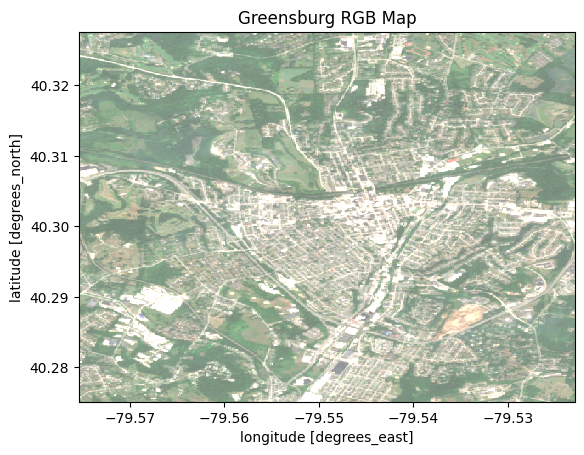

In [34]:
plot_data_summer = sentinel_2_summer_2024[['B04','B03','B02']].to_array()

plot_data_summer.plot.imshow(vmin=0, vmax=2500)
plt.title('Greensburg RGB Map')
plt.show()

Winter 2024

In [35]:
sentinel_2_winters_data = map_satellite_data('C:\\Users\\jrzem\\OneDrive\\Coding Applications\\EY Data Science Challenge 2025\\UHI_Index_Prediction_Model\\sentinel_2_winter.tiff',greensburg_location_df,sentinel_2_bands)

Extracting band values: 100%|██████████| 22500/22500 [04:35<00:00, 81.55it/s] 


In [ ]:
sentinel_2_winters_data.to_csv('C:\\Users\\jrzem\\OneDrive\\Coding Applications\\EY Data Science Challenge 2025\\UHI_Index_Prediction_Model\\sentinel_2_winters_data.csv')

In [37]:
sentinel_2_winters_data = pd.read_csv('C:\\Users\\jrzem\\OneDrive\\Coding Applications\\EY Data Science Challenge 2025\\UHI_Index_Prediction_Model\\sentinel_2_winters_data.csv',index_col=0)

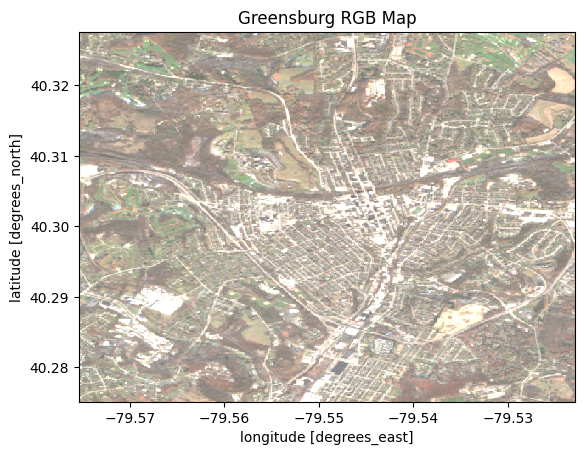

In [38]:
plot_data = sentinel_2_winters_2024[['B04','B03','B02']].to_array()

plot_data.plot.imshow(vmin=0, vmax=2500)
plt.title('Greensburg RGB Map')
plt.show()

In [39]:
((sentinel_2_summer_data - sentinel_2_winters_data) / sentinel_2_winters_data) * 100

,B01,B02,B03,B04,B05,B06,B07,B08,B8A,B11,B12
0,6.232092,-15.695744,-8.620207,-21.016484,0.513514,46.450893,60.606061,21.728749,47.318148,11.434185,-3.125775
1,6.232092,-2.400295,1.975226,-17.127759,-2.297431,26.712456,29.118774,44.880453,37.045381,8.851596,-6.541868
2,6.232092,-1.679808,7.452229,-12.011747,-1.954397,12.139019,25.036485,39.028867,14.770822,3.687231,-1.772057
3,6.584992,-9.134008,-4.455725,-22.913616,-9.508461,11.405396,17.149907,10.699762,14.386207,0.439902,-6.667885
4,6.584992,-13.287154,-7.724838,-28.077212,-9.256092,21.484163,31.375867,16.348774,19.223022,-1.854827,-10.864789
...,...,...,...,...,...,...,...,...,...,...,...
22495,6.254738,-9.887359,-4.864434,-25.925926,-5.958654,16.280460,22.261580,15.983097,19.422670,16.041979,-6.268897
22496,5.377907,-11.578947,-9.716909,-27.564103,-6.743356,14.658313,21.319520,14.265043,18.768620,11.123279,-5.603113
22497,5.377907,0.305717,-0.026378,-12.881773,-2.960592,13.068517,20.695387,10.045931,16.869455,15.481425,3.414823
22498,5.391121,1.506932,3.057459,-4.318009,0.520833,12.141247,15.908777,2.335820,18.953232,16.562452,8.023094


This an example of why different seasons require a different training model as you can see just how different the values are.

### Loading Sentinel 1:

In [40]:
sentinel_1_summer_data = map_satellite_data('C:\\Users\\jrzem\\OneDrive\\Coding Applications\\EY Data Science Challenge 2025\\UHI_Index_Prediction_Model\\sentinel_1_summer.tiff',greensburg_location_df,sentinel_1_all_bands)

Extracting band values: 100%|██████████| 22500/22500 [00:34<00:00, 654.10it/s] 


In [41]:
sentinel_1_summer_data

,vv,vh
0,255.0,107.5
1,238.0,96.0
2,212.5,91.5
3,130.0,96.5
4,211.0,125.0
...,...,...
22495,218.0,80.0
22496,242.5,124.5
22497,271.0,124.0
22498,135.5,68.5


### Loading Landsat 8:

In [42]:
landsat_thermal_data = map_satellite_data('C:\\Users\\jrzem\\OneDrive\\Coding Applications\\EY Data Science Challenge 2025\\UHI_Index_Prediction_Model\\landsat_july_28.tiff',greensburg_location_df,landsat_thermal)

Extracting band values: 100%|██████████| 22500/22500 [00:10<00:00, 2061.75it/s]


In [43]:
landsat_thermal_uhi_data = combine_two_datasets(greensburg_location_df,landsat_thermal_data) 

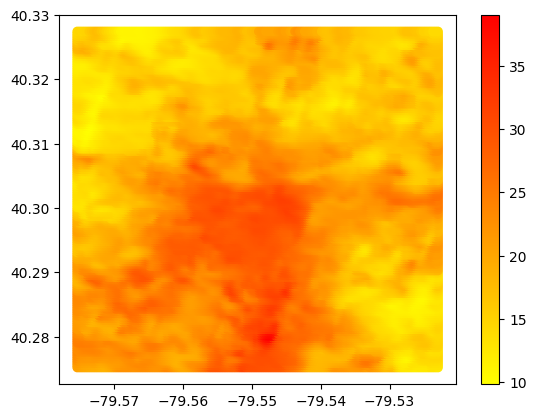

In [44]:
plt.scatter(landsat_thermal_uhi_data['Longitude'],landsat_thermal_uhi_data['Latitude'],c=landsat_thermal_uhi_data['lwir11'],cmap='autumn_r') 
plt.colorbar()

### Lidar Elevation:

In [45]:
lidar_elevation = map_satellite_data('C:\\Users\\jrzem\\OneDrive\\Coding Applications\\EY Data Science Challenge 2025\\UHI_Index_Prediction_Model\\lidar_elevation.tiff',greensburg_location_df,['elevation'])

Extracting band values: 100%|██████████| 22500/22500 [00:11<00:00, 2037.18it/s]


In [46]:
greensburg_elevation = combine_two_datasets(greensburg_location_df,lidar_elevation) 

In [ ]:
greensburg_elevation_mask = greensburg_elevation['elevation']==greensburg_elevation['elevation'].min()

# To account for a low outlier in the elevation data, we can drop the minimum value from the dataset.
greensburg_elevation_min_dropped = greensburg_elevation[~greensburg_elevation_mask]

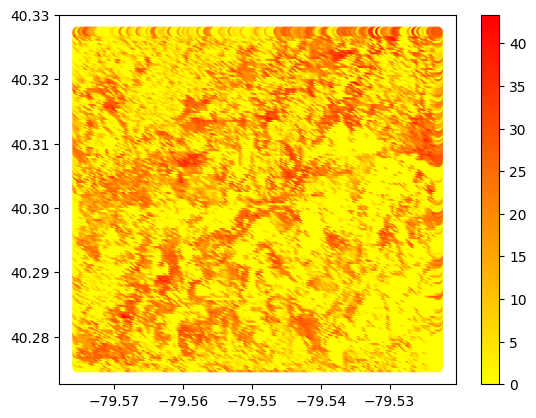

In [48]:
plt.scatter(greensburg_elevation_min_dropped['Longitude'],greensburg_elevation_min_dropped['Latitude'],c=greensburg_elevation_min_dropped['elevation'],cmap='autumn_r')
plt.colorbar()

# Model Development:

# Conclusion: